In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from src.utils.data_loader import LoadDataSet, CustomDataSet
from src.positioning.toa import toa_positioning
from src.utils.models import DenseNet
from sklearn.decomposition import PCA
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import tikzplotlib
import torch
import os
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### PCA Analysis

#### PCA with All Features Data
In this case we consider the data associated with each path, BS, and charcteristic (the 6 features for each path) as a unique set of features of dimension 600.

In [2]:
# Load the dataset with all the paths
dir_name = "Omni Spatial and Temporal Data/"
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = all_paths_dataset.get_datasets(scale=True, scaler=scaler, add_noise=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [3]:
# create the sk-learn PCA object and fit the training data
pca_all = PCA()
pca_all_components = pca_all.fit(train_set.X)

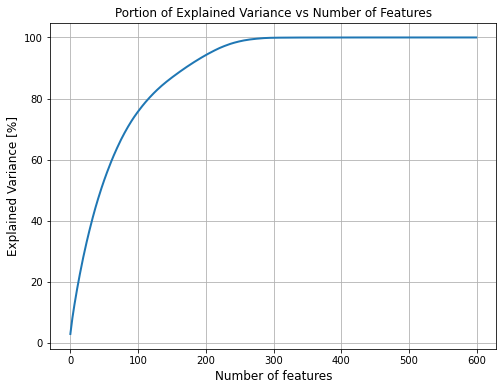

In [4]:
# let's visualize the amount of explained variance by increasing number of considered features
cum_explained_var = np.cumsum(pca_all_components.explained_variance_ratio_ * 100)
plt.figure(figsize=(8,6))
plt.plot(cum_explained_var, linewidth=2)
plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Explained Variance [%]", fontsize=12)
plt.title("Portion of Explained Variance vs Number of Features")
plt.grid()

tikzplotlib.save("./figures/explained_variance_noise_newarch.tex")

In [5]:
# retain a number of features with which we can explain at least 95 % of the total variance
I = np.where(cum_explained_var >= 99.0)[0]
num_features_95 = I[0]
print(f"The number of features needed to explain 99 % of the variance is: {num_features_95}")

# create an sk-learn PCA object with the above number of components
pca_95 = PCA(n_components=I[0])
x_train_95 = pca_95.fit_transform(train_set.X)
x_test_95 = pca_95.transform(test_set.X)
print(f"The reduced training data has shape: {x_train_95.shape}")
print(f"The percentage of explained variance is: {np.sum(pca_95.explained_variance_ratio_)*100}")

# create data loaders with the nre reduced data
train_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_train_95, train_set.y), batch_size=32, shuffle=True)
test_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_test_95, test_set.y), batch_size=1024, shuffle=False)

The number of features needed to explain 99 % of the variance is: 256
The reduced training data has shape: (75000, 256)
The percentage of explained variance is: 98.97890565182408


#### PCA for each feature
In this case we consider the data associated with the 6 features (delay, rx power, and the 4 angles of arrival and departure).
Specifically, based on the PCA of the data matrix, we select the 3 features that have the highest explanation power in the dataset. Each feature has 100 singular values associated (25 paths x 4 Base Stations)

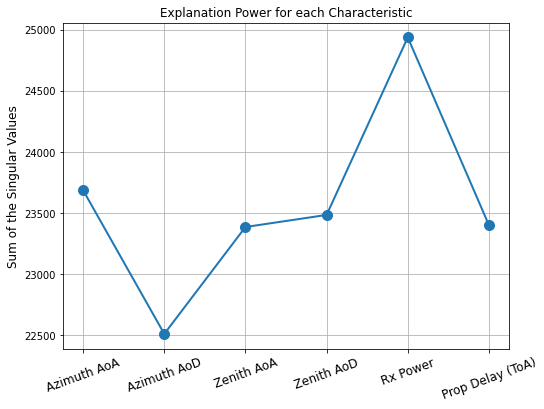

In [6]:
# we consider a PCA with 1 Principal Component to obtain the importance associated whith each characteristic
num_charac = 6
sinv_charac = np.zeros((num_charac, 1))
for i in range(num_charac):
    data = train_set.X[:, i*100:(i+1)*100]
    pca_i = PCA(100)
    pca_i_comp = pca_i.fit(data)
    sinv_charac[i] = np.sum(pca_i_comp.singular_values_)
    
plt.figure(figsize=(8,6))
plt.plot(sinv_charac, '-o', markersize=10, linewidth=2)
plt.ylabel("Sum of the Singular Values", fontsize=12)
plt.grid()
plt.title("Explanation Power for each Characteristic")
plt.xticks(np.arange(6), ["Azimuth AoA","Azimuth AoD","Zenith AoA","Zenith AoD","Rx Power","Prop Delay (ToA)"], rotation=20, fontsize=12)

tikzplotlib.save("./figures/characteristics_noise_newarch.tex")

From the plot above we can see that the 3 most important features are: Zenith AoD, Rx Power, and Propagation Delay.
Therefore, we will consider as input to our models the 100 samples (25x4) associated with these 3 characteristics, for a total of 300 features.

In [7]:
# get the full dataset
dir_name = "Omni Spatial and Temporal Data/"
full_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
(x_train, y_train), (x_test, y_test) = full_dataset.get_datasets(get_full_data=True, add_noise=True)

# selecting the feature corresponding to zenith AoD, Rx Power, and Propagation Delay (ToA) 
# [last 3 indexes in the right-most dimension]
x_train = np.reshape(x_train[:,:,:, [0,2,3,4,5]], (x_train.shape[0],x_train.shape[1]*x_train.shape[2]*5))
x_test = np.reshape(x_test[:,:,:,[0,2,3,4,5]], (x_test.shape[0],x_test.shape[1]*x_test.shape[2]*5))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 
train_set = CustomDataSet(x_train, y_train)
test_set = CustomDataSet(x_test, y_test)

train_feature_based_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_feature_based_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)


## Train with the 95% variance explained features

In [8]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape

# new deeper architecture for noisy data
layers_dim = [in_dim, 200, 100, 200, 100, out_dim]

dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
summary(dnn_model_95, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_95.parameters(), lr=0.001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 200]              51,400
|    └─Linear: 2-2                       [-1, 1, 100]              20,100
|    └─Linear: 2-3                       [-1, 1, 200]              20,200
|    └─Linear: 2-4                       [-1, 1, 100]              20,100
|    └─Linear: 2-5                       [-1, 1, 3]                303
Total params: 112,103
Trainable params: 112,103
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.43
Estimated Total Size (MB): 0.43


In [9]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_95_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_95(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_95_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_95(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 8896.09826316443
Training at epoch: 2 ended, Loss: 2369.704725050682
Training at epoch: 3 ended, Loss: 1130.40201182577
Training at epoch: 4 ended, Loss: 727.0049058178586
Training at epoch: 5 ended, Loss: 521.2374505833961
Training at epoch: 6 ended, Loss: 440.9001049393273
Training at epoch: 7 ended, Loss: 311.9828784897059
Training at epoch: 8 ended, Loss: 293.02207427301505
Training at epoch: 9 ended, Loss: 221.00195075220623
Training at epoch: 10 ended, Loss: 241.89146904896552
--> Testing at epoch: 10 ended, Loss: 2218.3775424441774
Training at epoch: 11 ended, Loss: 186.04537790952688
Training at epoch: 12 ended, Loss: 159.2755503914869
Training at epoch: 13 ended, Loss: 157.62697616860322
Training at epoch: 14 ended, Loss: 148.02954192291753
Training at epoch: 15 ended, Loss: 125.57418335013016
Training at epoch: 16 ended, Loss: 121.73970958315878
Training at epoch: 17 ended, Loss: 176.454464702476
Training at epoch: 18 ended, Loss: 110.3403528

Training at epoch: 140 ended, Loss: 12.462879990249771
--> Testing at epoch: 140 ended, Loss: 962.3862477637626
Training at epoch: 141 ended, Loss: 12.04252506197516
Training at epoch: 142 ended, Loss: 11.55732584030148
Training at epoch: 143 ended, Loss: 11.185209422083032
Training at epoch: 144 ended, Loss: 16.64422505727807
Training at epoch: 145 ended, Loss: 12.140060456031012
Training at epoch: 146 ended, Loss: 11.160977702702272
Training at epoch: 147 ended, Loss: 36.49825930208883
Training at epoch: 148 ended, Loss: 59.546452059578975
Training at epoch: 149 ended, Loss: 12.349458205720264
Training at epoch: 150 ended, Loss: 11.767593862660508
--> Testing at epoch: 150 ended, Loss: 964.1028583114212
Training at epoch: 151 ended, Loss: 10.497159133287013
Training at epoch: 152 ended, Loss: 12.291221061359087
Training at epoch: 153 ended, Loss: 10.512269232053399
Training at epoch: 154 ended, Loss: 11.067607355402599
Training at epoch: 155 ended, Loss: 12.916844031306256
Training a

Training at epoch: 277 ended, Loss: 7.088330959551571
Training at epoch: 278 ended, Loss: 8.781705162427532
Training at epoch: 279 ended, Loss: 7.230815550064471
Training at epoch: 280 ended, Loss: 5.75814848136373
--> Testing at epoch: 280 ended, Loss: 819.1487734511092
Training at epoch: 281 ended, Loss: 9.173665208773809
Training at epoch: 282 ended, Loss: 6.58840968981131
Training at epoch: 283 ended, Loss: 6.667461022175213
Training at epoch: 284 ended, Loss: 7.178389988763341
Training at epoch: 285 ended, Loss: 7.344812078534947
Training at epoch: 286 ended, Loss: 6.48980908070408
Training at epoch: 287 ended, Loss: 7.004444197125403
Training at epoch: 288 ended, Loss: 6.473493527328602
Training at epoch: 289 ended, Loss: 6.816238131183407
Training at epoch: 290 ended, Loss: 7.649775206279836
--> Testing at epoch: 290 ended, Loss: 786.360931834659
Training at epoch: 291 ended, Loss: 6.296762866015727
Training at epoch: 292 ended, Loss: 6.243764105561243
Training at epoch: 293 end

Training at epoch: 415 ended, Loss: 6.182992133721964
Training at epoch: 416 ended, Loss: 5.554101725131171
Training at epoch: 417 ended, Loss: 9.038558328009303
Training at epoch: 418 ended, Loss: 4.3373071407905615
Training at epoch: 419 ended, Loss: 5.023439519387057
Training at epoch: 420 ended, Loss: 5.155613344785704
--> Testing at epoch: 420 ended, Loss: 635.9028486303381
Training at epoch: 421 ended, Loss: 6.146544945931678
Training at epoch: 422 ended, Loss: 8.482048667992748
Training at epoch: 423 ended, Loss: 5.881339661293876
Training at epoch: 424 ended, Loss: 5.143901332500851
Training at epoch: 425 ended, Loss: 5.292481360327669
Training at epoch: 426 ended, Loss: 6.21352290029005
Training at epoch: 427 ended, Loss: 5.5533466770889
Training at epoch: 428 ended, Loss: 5.6207352030907884
Training at epoch: 429 ended, Loss: 10.030828470968142
Training at epoch: 430 ended, Loss: 5.669697596961727
--> Testing at epoch: 430 ended, Loss: 628.8446122762319
Training at epoch: 431

In [10]:
torch.save(dnn_model_95.state_dict(), "../models/dnn_model_95_v2_noise_newarch")

In [11]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 200, 100, 200, 100, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
dnn_model_95.load_state_dict(torch.load("../models/dnn_model_95_v2_noise_newarch"))

# evaluate the model over the entire data and the test data
train_error_95 = []
test_error_95 = []
all_error_95 = []

for xx, yy in train_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_95.extend(error)
    all_error_95.extend(error)

for xx, yy in test_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_95.extend(error)
    test_error_95.extend(error)

train_error_95 = np.array(train_error_95)
test_error_95 = np.array(test_error_95)
all_error_95 = np.array(all_error_95)

## Train over the 3 most relevant carachteristics

In [12]:
in_dim = 500
out_dim = all_paths_dataset.output_shape

# new deeper arch
layers_dim = [in_dim, 300, 200, 100, 200, 300, 200, out_dim]

dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
summary(dnn_model_3, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_3.parameters(), lr=0.001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 300]              150,300
|    └─Linear: 2-2                       [-1, 1, 200]              60,200
|    └─Linear: 2-3                       [-1, 1, 100]              20,100
|    └─Linear: 2-4                       [-1, 1, 200]              20,200
|    └─Linear: 2-5                       [-1, 1, 300]              60,300
|    └─Linear: 2-6                       [-1, 1, 200]              60,200
|    └─Linear: 2-7                       [-1, 1, 3]                603
Total params: 371,903
Trainable params: 371,903
Non-trainable params: 0
Total mult-adds (M): 0.37
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.42
Estimated Total Size (MB): 1.43


In [13]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_feature_based_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_3(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_feature_based_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_3(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 6524.165183109635
Training at epoch: 2 ended, Loss: 1106.53414054454
Training at epoch: 3 ended, Loss: 733.6767439077332
Training at epoch: 4 ended, Loss: 540.1637692955981
Training at epoch: 5 ended, Loss: 418.1069789860436
Training at epoch: 6 ended, Loss: 367.7924058933714
Training at epoch: 7 ended, Loss: 336.4226151619348
Training at epoch: 8 ended, Loss: 313.2973502455311
Training at epoch: 9 ended, Loss: 256.30034490656936
Training at epoch: 10 ended, Loss: 242.17172160164895
--> Testing at epoch: 10 ended, Loss: 1659.173703992689
Training at epoch: 11 ended, Loss: 219.73287883472116
Training at epoch: 12 ended, Loss: 223.50262052451384
Training at epoch: 13 ended, Loss: 207.22798744566205
Training at epoch: 14 ended, Loss: 284.0676299443424
Training at epoch: 15 ended, Loss: 178.87565024965045
Training at epoch: 16 ended, Loss: 130.47314703708622
Training at epoch: 17 ended, Loss: 84.31563244866837
Training at epoch: 18 ended, Loss: 90.36310485

Training at epoch: 140 ended, Loss: 10.768050579385953
--> Testing at epoch: 140 ended, Loss: 3481.331750586226
Training at epoch: 141 ended, Loss: 13.282156643810533
Training at epoch: 142 ended, Loss: 13.345703532874788
Training at epoch: 143 ended, Loss: 11.49783386096816
Training at epoch: 144 ended, Loss: 16.482839010172736
Training at epoch: 145 ended, Loss: 10.490902201002369
Training at epoch: 146 ended, Loss: 16.8146432932123
Training at epoch: 147 ended, Loss: 13.187499440875884
Training at epoch: 148 ended, Loss: 17.256617341127004
Training at epoch: 149 ended, Loss: 21.243221455466625
Training at epoch: 150 ended, Loss: 14.535569332158607
--> Testing at epoch: 150 ended, Loss: 2965.455690564336
Training at epoch: 151 ended, Loss: 11.890103210259623
Training at epoch: 152 ended, Loss: 15.487870883819593
Training at epoch: 153 ended, Loss: 25.064912736009006
Training at epoch: 154 ended, Loss: 11.623806191894381
Training at epoch: 155 ended, Loss: 14.314785649090904
Training 

Training at epoch: 276 ended, Loss: 10.105939594857116
Training at epoch: 277 ended, Loss: 13.739481612938256
Training at epoch: 278 ended, Loss: 10.145291325022743
Training at epoch: 279 ended, Loss: 6.545090159153369
Training at epoch: 280 ended, Loss: 6.558563298892243
--> Testing at epoch: 280 ended, Loss: 1900.2651797114193
Training at epoch: 281 ended, Loss: 8.127968872417362
Training at epoch: 282 ended, Loss: 11.681052562268928
Training at epoch: 283 ended, Loss: 8.9233984470164
Training at epoch: 284 ended, Loss: 6.569048578116674
Training at epoch: 285 ended, Loss: 7.411722345106024
Training at epoch: 286 ended, Loss: 12.439287122860296
Training at epoch: 287 ended, Loss: 9.489416647791456
Training at epoch: 288 ended, Loss: 8.637996739800066
Training at epoch: 289 ended, Loss: 8.332896052926474
Training at epoch: 290 ended, Loss: 8.104892684076834
--> Testing at epoch: 290 ended, Loss: 2142.7446644241745
Training at epoch: 291 ended, Loss: 7.043676093525854
Training at epoch

Training at epoch: 413 ended, Loss: 6.19964158946947
Training at epoch: 414 ended, Loss: 5.668038871864003
Training at epoch: 415 ended, Loss: 5.7364365267773945
Training at epoch: 416 ended, Loss: 5.507271271262559
Training at epoch: 417 ended, Loss: 6.910455890737296
Training at epoch: 418 ended, Loss: 10.528717601767172
Training at epoch: 419 ended, Loss: 6.402253723032645
Training at epoch: 420 ended, Loss: 8.29933504658551
--> Testing at epoch: 420 ended, Loss: 1712.6608249045707
Training at epoch: 421 ended, Loss: 6.034732472723661
Training at epoch: 422 ended, Loss: 9.06222460904626
Training at epoch: 423 ended, Loss: 8.378986314447667
Training at epoch: 424 ended, Loss: 5.023014009151442
Training at epoch: 425 ended, Loss: 5.3546468396337366
Training at epoch: 426 ended, Loss: 5.88039985288939
Training at epoch: 427 ended, Loss: 9.998137768624993
Training at epoch: 428 ended, Loss: 8.500829217834685
Training at epoch: 429 ended, Loss: 9.707637165746185
Training at epoch: 430 en

In [14]:
torch.save(dnn_model_3.state_dict(), "../models/dnn_model_3_v2_noise_newarch")

In [15]:
in_dim = 500
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 300, 200, 100, 200, 300, 200, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
dnn_model_3.load_state_dict(torch.load("../models/dnn_model_3_v2_noise_newarch"))

# evaluate the model over the entire data and the test data
train_error_3 = []
test_error_3 = []
all_error_3 = []

for xx, yy in train_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_3.extend(error)
    all_error_3.extend(error)

for xx, yy in test_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_3.extend(error)
    test_error_3.extend(error)

train_error_3 = np.array(train_error_3)
test_error_3 = np.array(test_error_3)
all_error_3 = np.array(all_error_3)

### Results

In [16]:
# import baseline results
true_cord_tensor = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "all_true_tensor")))['true_cord_tensor']
tot_points = true_cord_tensor.shape[0]*true_cord_tensor.shape[1]
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))

with open('../models/best_toa_estimated_noise.npy', 'rb') as f:
    best_est_3d_coords = np.load(f)
    
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))

In [17]:
#hashim_baseline = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "baselineerror")))["err_data"].reshape(-1)
#print(hashim_baseline.shape)

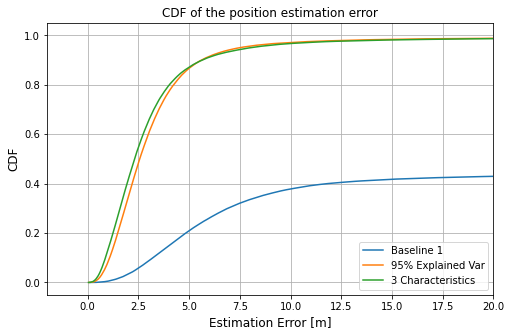

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(8, 5)) 
ax.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), np.sort(all_error_95), np.linspace(0,1,len(all_error_95)), 
       np.sort(all_error_3), np.linspace(0,1,len(all_error_3)))
tikzplotlib.clean_figure(fig=figure, target_resolution=600)

#plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
#plt.plot(np.sort(all_error), np.linspace(0,1,len(all_error)), linewidth=2, label="Min Delay")
#plt.plot(np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), linewidth=2, label="All Paths")

plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(["Baseline 1", "95% Explained Var", "3 Characteristics", "Baseline 2"], loc="lower right")

tikzplotlib.save("./figures/pca_95_3charac_vs_baselines_noise_newarch_v2.tex")
# plt.savefig("./dnn_vs_baseline.png")

In [19]:
print(all_error_95.shape)
# print(f"The average error for the Baseline is {np.mean(baseline_error)}")
# print(f"The average error for Hashim Baseline is {np.mean(hashim_baseline)}")
# print(f"The average error for the Min Delay DNN is {np.mean(all_error)}")
# print(f"The average error for the All Paths DNN is {np.mean(all_error_all_paths)}")

(150000,)


In [20]:
baseline_err_sort = np.sort(baseline_error)
y = np.linspace(0,1.0,len(baseline_err_sort))
print(f"BASELINE 1: the 80% percentile error in meters is {baseline_err_sort[y>=0.8][0]}")

#baseline_hash_sort = np.sort(hashim_baseline)
#y = np.linspace(0,1.0,len(baseline_hash_sort))
#print(f"BASELINE 2: the 80% percentile error in meters is {baseline_hash_sort[y>=0.8][0]}")

all_error_95_sort = np.sort(all_error_95)
y = np.linspace(0,1.0,len(all_error_95_sort))
print(f"95% Explained: the 80% percentile error in meters is {all_error_95_sort[y>=0.8][0]}")

all_error_3_sort = np.sort(all_error_3)
y = np.linspace(0,1.0,len(all_error_3_sort))
print(f"3 CHARACT: the 80% percentile error in meters is {all_error_3_sort[y>=0.8][0]}")


BASELINE 1: the 80% percentile error in meters is 377.8483316940807
95% Explained: the 80% percentile error in meters is 4.236097812652588
3 CHARACT: the 80% percentile error in meters is 4.025002479553223
